# Noise variance experiment

In [1]:
import os 
import torch

def load_all_batches(path : str, max_num_batches : int=None) -> dict[str, torch.Tensor]:
    # during inference, the samples are saved as batches 
    # this function concatenates all batches into a single list
    
    # find all files on the form batch_*.pt
    files = [f for f in os.listdir(path) if f.startswith("batch_") and f.endswith(".pt")]
    if max_num_batches is not None:
        files = files[:max_num_batches]
    files.sort()  # sort files to ensure consistent order
    x0s, x1s, x0_recons, trajectories = [], [], [], []
    for file in files:
        batch = torch.load(os.path.join(path, file), weights_only=True)
        x0s.append(batch["x0"])
        x1s.append(batch["x1"])
        x0_recons.append(batch["x0_recon"])
        trajectories.append(batch["trajectory"])
    # concatenate all batches into a single tensor
    x0 = torch.cat(x0s, dim=0)
    x1 = torch.cat(x1s, dim=0)
    x0_recon = torch.cat(x0_recons, dim=0)
    trajectory = torch.cat(trajectories, dim=1)
    return {
        "x0": x0,
        "x1": x1,
        "x0_recon": x0_recon,
        "trajectory": trajectory
    }
    

In [2]:
from src.callbacks.metrics import calculate_curvature_displacement
from torch import Tensor

def calculate_gfb_curvature(trajectories : Tensor, timeschedule : Tensor) -> Tensor:
    timeschedule = torch.cat([torch.tensor([0.0]), timeschedule], dim=0)
    n_steps = trajectories.shape[0]
    
    forward = trajectories[:n_steps // 2]
    backward = trajectories[n_steps // 2:]
    
    forward_Ct = calculate_curvature_displacement(forward, timeschedule)
    backward_Ct = calculate_curvature_displacement(backward, timeschedule) # ideally, timeschedule should be reversed but it is symmetric
    backward_Ct = backward_Ct.flip(dims=[0])  # reverse the backward curvature
    
    C_ts = torch.cat([forward_Ct, backward_Ct], dim=1)
    return C_ts

def calculate_gfb_curvature_from_path(path : str, max_num_batches : int) -> Tensor:
    batches = load_all_batches(path, max_num_batches)
    params = torch.load(path + "/params.pt", weights_only=True)
    timeschedule = params['timeschedule']
    trajectories = batches['trajectory']
    print(f"Trajectory shape: {trajectories.shape}, timeschedule length: {len(timeschedule)}")
    return calculate_gfb_curvature(trajectories, timeschedule)

def calculate_dsb_curvature_from_path(path : str, max_num_batches : int) -> Tensor:
    batches = load_all_batches(path, max_num_batches)
    params = torch.load(path + "/params.pt", weights_only=True)
    timeschedule = params['timeschedule']
    trajectories = batches['trajectory']
    print(f"Trajectory shape: {trajectories.shape}, timeschedule length: {len(timeschedule)}")
    return calculate_curvature_displacement(trajectories, timeschedule)

gfb_path = "/work3/s214630/Latent-DSB/test_results/test_clip/gfb_30"
dsb_path = "/work3/s214630/Latent-DSB/test_results/test_clip/stft_det_30"
gfb_cts = calculate_gfb_curvature_from_path(gfb_path, max_num_batches=1)
dsb_cts = calculate_dsb_curvature_from_path(dsb_path, max_num_batches=1)


INFO:speechbrain.utils.quirks:Applied quirks (see `speechbrain.utils.quirks`): [allow_tf32, disable_jit_profiling]
INFO:speechbrain.utils.quirks:Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []


Trajectory shape: torch.Size([32, 16, 1, 65536]), timeschedule length: 15
Trajectory shape: torch.Size([31, 16, 1, 65536]), timeschedule length: 31


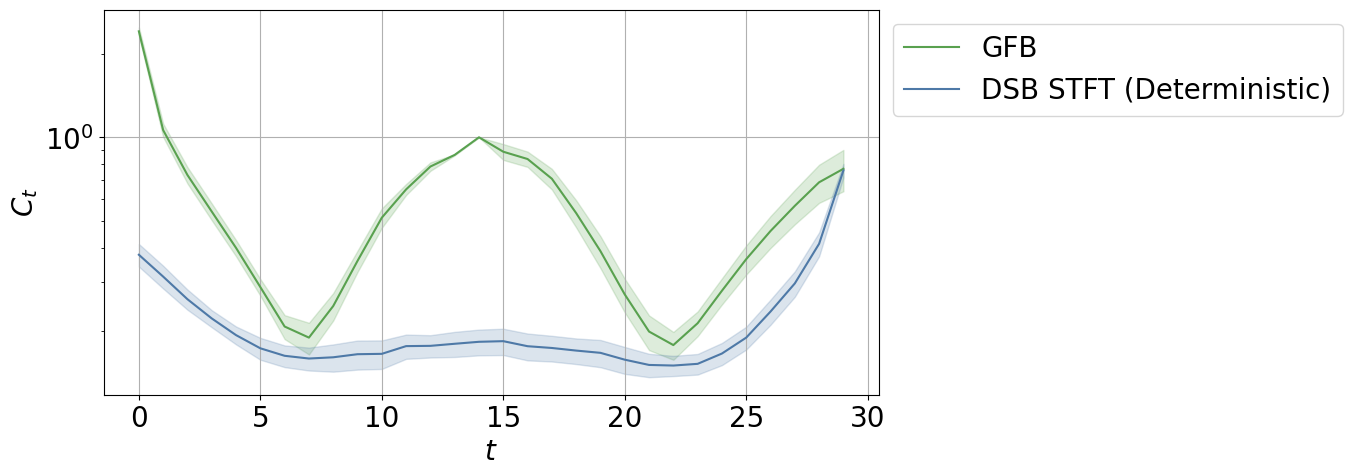

In [4]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 1, figsize=(10, 5))
plt.rcParams.update({'font.size': 20})
axs.plot(gfb_cts.mean(dim=0).cpu().numpy(), label="GFB", color='#59A14F')
axs.fill_between(
    range(len(gfb_cts.mean(dim=0))),
    gfb_cts.mean(dim=0).cpu().numpy() - gfb_cts.std(dim=0).cpu().numpy(),
    gfb_cts.mean(dim=0).cpu().numpy() + gfb_cts.std(dim=0).cpu().numpy(),
    alpha=0.2, color='#59A14F'
)
axs.plot(dsb_cts.mean(dim=0).cpu().numpy(), label="DSB STFT (Deterministic)", color='#4E79A7')
axs.fill_between(
    range(len(dsb_cts.mean(dim=0))),
    dsb_cts.mean(dim=0).cpu().numpy() - dsb_cts.std(dim=0).cpu().numpy(),
    dsb_cts.mean(dim=0).cpu().numpy() + dsb_cts.std(dim=0).cpu().numpy(),
    alpha=0.2, color='#4E79A7'
)
axs.grid(True)
axs.set_xlabel("$t$")
axs.set_yscale('log')
axs.set_ylabel("$C_t$")
axs.legend(loc='upper left', bbox_to_anchor=(1, 1))


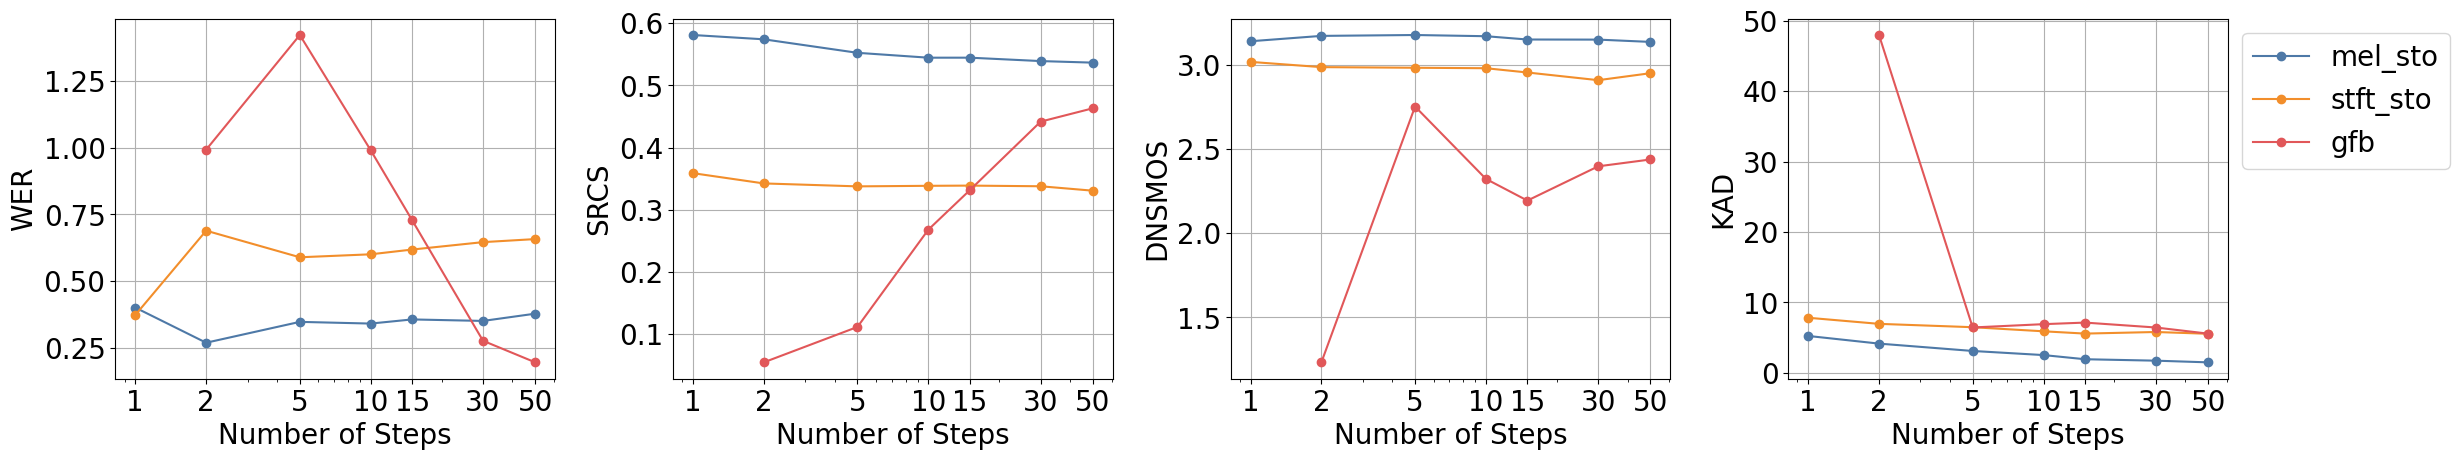

In [7]:
import matplotlib.pyplot as plt
import torch

data = dict()
what_test = "clip"

num_steps = [50, 30, 15, 10, 5, 2, 1]
for model in ['mel_sto', 'stft_sto', 'gfb']:
    data[model] = dict()
    for metric in ['wer', 'srcs', 'dnsmos', 'kad']:
        metric_list = []
        for num_step in num_steps:
            if num_step == 1 and model == 'gfb':
                continue
            path = f"test_results/test_{what_test}/{model}_{num_step}"
            metrics = torch.load(path + "/metrics.pt", weights_only=True)
            value = metrics[metric]
            value = torch.tensor(value)
            value = value.mean().item()
            
            metric_list.append(value)
            
        data[model][metric] = metric_list

fig, axs = plt.subplots(1, 4, figsize=(25, 5))
axs : list[plt.Axes]
plt.rcParams.update({'font.size': 20})
colors = ['#4E79A7', '#F28E2B', '#E15759']

for i, (model, metrics) in enumerate(data.items()):
    color = colors[i]
    
    xvalues = num_steps if model != 'gfb' else num_steps[:-1]  # GFB does not have num_step=1
    axs[0].plot(xvalues, metrics['wer'], marker='o', linestyle='-', color=color, label=model)
    axs[1].plot(xvalues, metrics['srcs'], marker='o', linestyle='-', color=color)
    axs[2].plot(xvalues, metrics['dnsmos'], marker='o', linestyle='-', color=color)
    axs[3].plot(xvalues, metrics['kad'], marker='o', linestyle='-', color=color, label=model)
for i in range(4):
    axs[i].set_xlabel("Number of Steps")
    axs[i].set_ylabel(["WER", "SRCS", "DNSMOS", "KAD"][i])
    axs[i].set_xticks(num_steps)
    axs[i].grid(True)
    axs[i].set_xscale('log')
    axs[i].set_xticks(num_steps)
    axs[i].set_xticklabels(num_steps)
    if i == 3:
        axs[i].legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()

    